# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'VertebralColumn_c3'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([310, 6]), torch.Size([310]), 310, 6, 3)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.3557, 0.5198, 0.2292, 0.2509, 0.3075, 0.0252],
        [0.1245, 0.2967, 0.0986, 0.1446, 0.4767, 0.0364],
        [0.4117, 0.5139, 0.3230, 0.3076, 0.3862, 0.0175],
        [0.4162, 0.5573, 0.2713, 0.2894, 0.3419, 0.0518],
        [0.2272, 0.2894, 0.1282, 0.2470, 0.4096, 0.0442],
        [0.1360, 0.3657, 0.0995, 0.1199, 0.6479, 0.0309],
        [0.2631, 0.4003, 0.2074, 0.2239, 0.5430, 0.0397],
        [0.1854, 0.3092, 0.1346, 0.1966, 0.5075, 0.0009],
        [0.1701, 0.3587, 0.2568, 0.1563, 0.5906, 0.0567],
        [0.1017, 0.2065, 0.2501, 0.1694, 0.1523, 0.0273]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))


random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(186, 62, 62)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Aging Aware PNN

In [12]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

In [13]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, config.M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(config.K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [14]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [15]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.27476 | Loss: 0.983739197 |
| Epoch:     7 | Accuracy: 0.42048 | Loss: 0.867661595 |
| Epoch:    14 | Accuracy: 0.40968 | Loss: 0.859353244 |
| Epoch:    21 | Accuracy: 0.44419 | Loss: 0.825351536 |
| Epoch:    28 | Accuracy: 0.45798 | Loss: 0.807668388 |
| Epoch:    35 | Accuracy: 0.43734 | Loss: 0.889207542 |
| Epoch:    42 | Accuracy: 0.47379 | Loss: 0.773121536 |
| Epoch:    49 | Accuracy: 0.49290 | Loss: 0.747233629 |
| Epoch:    56 | Accuracy: 0.53976 | Loss: 0.712426901 |
| Epoch:    63 | Accuracy: 0.57863 | Loss: 0.711890519 |
| Epoch:    70 | Accuracy: 0.58452 | Loss: 0.658865511 |
| Epoch:    77 | Accuracy: 0.60105 | Loss: 0.669914186 |
| Epoch:    84 | Accuracy: 0.57960 | Loss: 0.646424294 |
| Epoch:    91 | Accuracy: 0.60605 | Loss: 0.631422341 |
| Epoch:    98 | Accuracy: 0.61798 | Loss: 0.615834415 |
| Epoch:   105 | Accuracy: 0.62589 | Loss: 0.590681911 |
| Epoch:   112 | Accuracy: 0.61000 | Loss: 0.617542326 |
| Epoch:   119 | Accuracy: 0.63

(118, 0.5719727873802185)

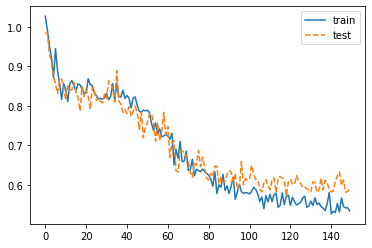

In [16]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [17]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.60387 | Loss: 0.623336136 |
| Epoch:    12 | Accuracy: 0.62855 | Loss: 0.606247187 |
| Epoch:    24 | Accuracy: 0.62758 | Loss: 0.594776630 |
| Epoch:    36 | Accuracy: 0.62581 | Loss: 0.572488010 |
| Epoch:    48 | Accuracy: 0.63621 | Loss: 0.587996304 |
| Epoch:    60 | Accuracy: 0.63597 | Loss: 0.588110566 |
| Epoch:    72 | Accuracy: 0.64032 | Loss: 0.580983937 |
| Epoch:    84 | Accuracy: 0.62371 | Loss: 0.606910288 |
| Epoch:    96 | Accuracy: 0.63194 | Loss: 0.592594326 |
| Epoch:   108 | Accuracy: 0.63524 | Loss: 0.595160246 |
| Epoch:   120 | Accuracy: 0.62685 | Loss: 0.584094405 |
| Epoch:   132 | Accuracy: 0.64847 | Loss: 0.591320693 |
| Epoch:   144 | Accuracy: 0.64145 | Loss: 0.596381128 |
| Epoch:   156 | Accuracy: 0.64387 | Loss: 0.567667842 |
| Epoch:   168 | Accuracy: 0.64387 | Loss: 0.588528991 |
| Epoch:   180 | Accuracy: 0.61250 | Loss: 0.597235143 |
| Epoch:   192 | Accuracy: 0.63661 | Loss: 0.584303856 |
| Epoch:   204 | Accuracy: 0.64

(208, 0.562817394733429)

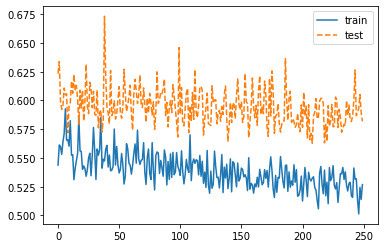

In [18]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [19]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.63355 | Loss: 0.608574152 |
| Epoch:    12 | Accuracy: 0.65242 | Loss: 0.575336039 |
| Epoch:    24 | Accuracy: 0.64573 | Loss: 0.572335064 |
| Epoch:    36 | Accuracy: 0.63016 | Loss: 0.584160328 |
| Epoch:    48 | Accuracy: 0.63306 | Loss: 0.602508128 |
| Epoch:    60 | Accuracy: 0.63774 | Loss: 0.592527986 |
| Epoch:    72 | Accuracy: 0.65274 | Loss: 0.570886731 |
| Epoch:    84 | Accuracy: 0.64621 | Loss: 0.575076222 |
| Epoch:    96 | Accuracy: 0.63065 | Loss: 0.612223685 |
| Epoch:   108 | Accuracy: 0.63355 | Loss: 0.601314485 |
| Epoch:   120 | Accuracy: 0.63484 | Loss: 0.575380087 |
| Epoch:   132 | Accuracy: 0.62403 | Loss: 0.596491098 |
| Epoch:   144 | Accuracy: 0.65145 | Loss: 0.579584301 |
| Epoch:   156 | Accuracy: 0.64790 | Loss: 0.590177238 |
| Epoch:   168 | Accuracy: 0.64766 | Loss: 0.588706672 |
| Epoch:   180 | Accuracy: 0.63315 | Loss: 0.598215401 |
| Epoch:   192 | Accuracy: 0.63613 | Loss: 0.581338108 |
| Epoch:   204 | Accuracy: 0.63

(11, 0.553124189376831)

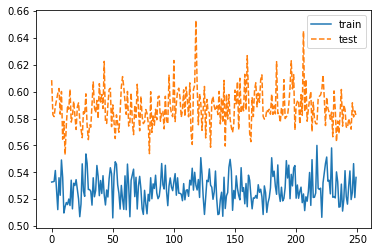

In [20]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [21]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)